# Extra - AutoEncoders com MLP

Iremos replicar o que vimos no notebook da parte prática, porém, desta vez, utilizando redes _fully connected_ (MLPs) para a tarefa de reconstrução dos dados do MNIST.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.v2 as T 

from tqdm.notebook import tqdm
from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

## Carregamento e visualização dos dados

In [ ]:
mnist_datapath = '/pgeoprj2/ciag2024/dados/'

transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True)
])

train_dataset = MNIST(
    mnist_datapath,
    train=True,
    transform=transforms,
    download=False
)

test_dataset = MNIST(
    mnist_datapath,
    train=False,
    transform=transforms,
    download=False
)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(10, 4))

for i in range (0, 10):
    # Obtendo um índice aleatório de um dado da classe "i"
    label_idx = torch.where(train_dataset.targets == i)[0]
    random_idx = torch.randint(len(label_idx), size=(1,)).item()

    # Obtendo o dado da classe
    sample_idx = label_idx[random_idx]
    image, _ = train_dataset[sample_idx]

    axs[i].axis('off')
    axs[i].imshow(image.squeeze(), cmap='gray')
    
fig.tight_layout()

## Definindo a arquitetura

- Para treinar, faça uma rede autoencoder MLP simples. Tome cuidado com o local ou tipo de função de ativação que você utilizará.
- **Nota:** no `forward` do seu modelo, retorne uma tupla `outputs, latent`, indicando a imagem reconstruída e o espaço latente obtido pelo encoder.

In [ ]:
class AutoEncoderMLP(nn.Module):
    def __init__(self, img_size: int = 28):
        super().__init__()

        num_features = 1 * img_size * img_size

        self.encoder = nn.Sequential(
            # Implemente uma rede MLP para o encoder
        )

        self.decoder = nn.Sequential(
            # Implemente uma rede MLP para o decoder
        )

    def forward(self, x):
        # Implemente aqui o seu forward

        return outputs, latent

In [ ]:
model = AutoEncoderMLP(img_size=28)
model = model.to(device)

summary(model, (1, 28, 28))

## Treinamento do modelo

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Number of batches in train:', len(train_dataloader))
print('Number of batches in test:', len(test_dataloader))

In [ ]:
# Redefinindo o modelo por praticidade
model = AutoEncoderMLP(img_size=28)
model = model.to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader=None, epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for i, (inputs, _) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs = inputs.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs, _ = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            loss = loss_fn(outputs, inputs)
            loss /= inputs.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, _ in val_loader:
                    inputs = inputs.to(device)

                    outputs, _ = model(inputs)
                    loss = loss_fn(outputs, inputs)
                    loss /= inputs.size(0)

                    val_loss += loss.item()

            val_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}")

In [ ]:
epochs = 20
train(model, optimizer, criterion, train_dataloader, test_dataloader, epochs=epochs)

## Análise da reconstrução

In [ ]:
def plot_reconstructions(model, dataset, n=8, figsize=(12, 6)):
    fig, axes = plt.subplots(2, n, figsize=figsize)
    images = torch.cat([dataset[i][0].unsqueeze(0) for i in range(n)], dim=0).to(device)

    model.to(device)
    model.eval()
    with torch.no_grad():
        reconstructions, _ = model(images)

    for i, (ax, im, rec) in enumerate(zip(range(n), images, reconstructions)):
        im = im.cpu().squeeze()
        rec = rec.cpu().squeeze()

        axes[0][ax].imshow(im, cmap="gray")
        axes[0][ax].axis("off")
        axes[1][ax].imshow(rec, cmap="gray")
        axes[1][ax].axis("off")

        if i == n//2:
            axes[0][ax].set_title("Sample")
            axes[1][ax].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_reconstructions(model, test_dataset, n=8)

## Análise do espaço latente

In [ ]:
def plot_latent_space(encoder, dataloader, n_classes=10):
    # Get the latent representations for all test data
    labels_agg = []
    latent_representations = []
    classes = list(range(n_classes,))

    encoder.eval()    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            latent_vectors = encoder(images)
            latent_representations.append(latent_vectors.cpu().numpy())
            labels_agg.append(labels.numpy())

    # Concatenate all latent representations
    latent_representations = np.concatenate(latent_representations, axis=0)
    labels_agg = np.concatenate(labels_agg, axis=0)

    # Plot the latent representations
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('jet', 10)
    for c in classes:
        indices = np.where(labels_agg == c)
        plt.scatter(
            latent_representations[indices, 0],
            latent_representations[indices, 1],
            s=3,
            label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )
    # add the labels mapping
    plt.legend(markerscale=5)
    plt.title('Latent Representations of Test Data')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

In [ ]:
plot_latent_space(model.encoder, test_dataloader)

## **Desafio 1:** clusterização do espaço latente

No caso do MNIST, sempre teremos um par (imagem, rótulo) ao nosso dispor. Porém, em casos reais, AutoEncoders (e outras técnicas de aprendizado não-supervisionado) são usados para agrupar os dados e facilitar, por exemplo, a rotulação de grupos de dados.

- **Desafio:** Utilize algum algoritmo de [_clustering_](https://scikit-learn.org/stable/modules/clustering.html) do `sklearn`, como KMeans, HDBScan, entre outros, para realizar uma rotulação automática desses dados. Compare essa rotulação com os rótulos de verdade observados no plot acima.

<div>
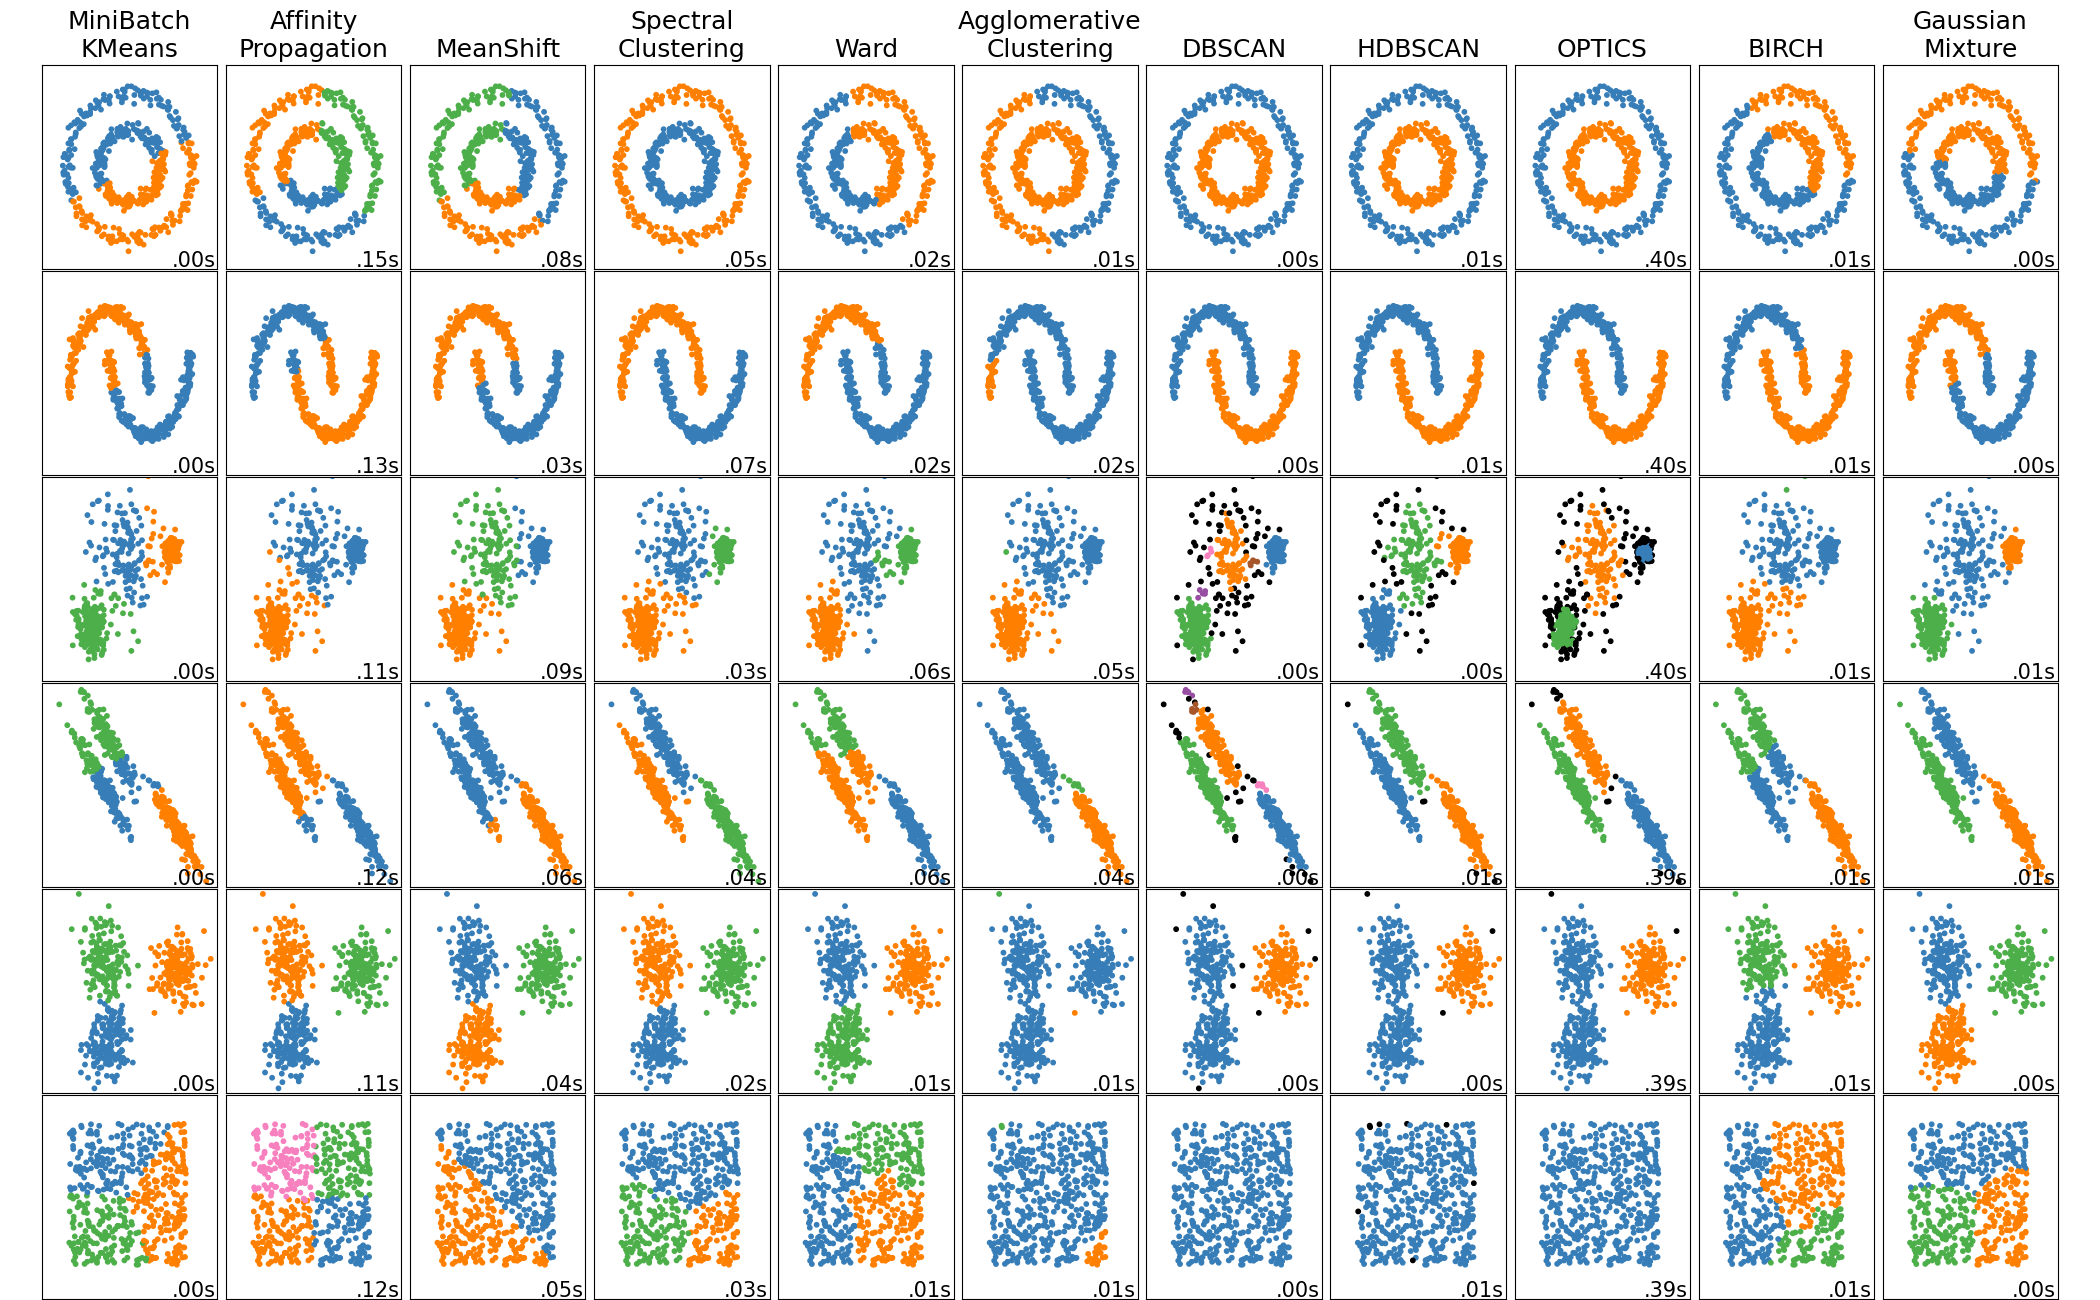
</div>

Para facilitar, iremos providenciar uma matriz com todas as representações latentes dos dígitos e seus rótulos.

In [ ]:
labels_agg = []
latent_representations = []

model.encoder.eval()    
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        latent_vectors = model.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

print('Latent representations shape:', latent_representations.shape)
print('Labels shape:', labels_agg.shape)

In [ ]:
# Implemente aqui o clustering do seu espaço latente
# ...

# Salve nessa variável os grupos retornados pelo seu algoritmo
clustering_groups = ...

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('jet', 10)

for c in range(10):
    indices = np.where(labels_agg == c)
    axs[0].scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )

    indices = np.where(clustering_groups == c)
    axs[1].scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )
    
# add the labels mapping
axs[0].set_title('Ground Truth Groups')
axs[1].set_title('Clustering Groups')

axs[0].legend(markerscale=5)

for i in range(2):
    axs[i].set_xlabel('Latent Dimesion 1')
    axs[i].set_ylabel('Latent Dimesion 2')
    axs[i].grid(True)

fig.tight_layout()

## **Desafio 2:** geração de imagens a partir do espaço latente

- Teoricamente, podemos gerar números do MNIST a partir do espaço latente. Faça a operação de _sampling_ de um par `(latent1, latent2)` e observe o dígito gerado pelo seu autoencoder. Explore algumas regiões do espaço latente, principalmente aquelas que não estão bem divididas.

> **Pergunta:** Como podemos fazer um _sampling_ mais "eficiente" do espaço latente? Do ponto de vista de gerar imagens aleatórias mais facilmente?

In [ ]:
# Implemente aqui a passagem do espaço latente -> imagem gerada